<a href="https://colab.research.google.com/github/saatvik1879/mlprojects/blob/main/convmodel_for_implementation_of_neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTING REQUIRED LIBRARIES

In [1]:
import tensorflow as tf
import numpy as np
import PIL
from tensorflow.keras.applications.vgg16 import VGG16

In [2]:
from tensorflow.keras.preprocessing.image import array_to_img

# IMPORTING IMAGES FOR STYLE AND CONTENT

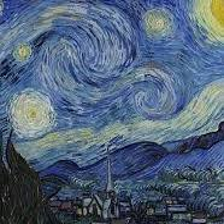

In [120]:
rawstyle  = PIL.Image.open("/content/style3.jpeg")
rawstyle = rawstyle.resize((224,224))
rawstyle

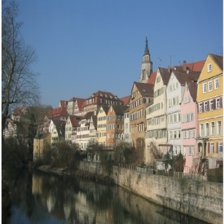

In [134]:
rawcontent = PIL.Image.open("/content/house.jpg")
rawcontent = rawcontent.resize((224,224))
rawcontent

In [135]:
content_tensor = tf.convert_to_tensor(rawcontent)
style_tensor = tf.convert_to_tensor(rawstyle)
content_tensor = tf.cast(content_tensor,tf.float32)
style_tensor = tf.cast(style_tensor,tf.float32)
content_tensor /= 255.0
style_tensor /= 255.0

In [136]:
content_tensor = tf.reshape(content_tensor,(1,224,224,3))
style_tensor = tf.reshape(style_tensor,(1,224,224,3))


# LOADING VGG MODEL

In [9]:
vgg_model = VGG16(weights='imagenet', include_top=True)

# Summary of the VGG16 model architecture
vgg_model.summary()

553467096/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [10]:
prep_content = tf.keras.applications.vgg16.preprocess_input(content_tensor)
prep_style =tf.keras.applications.vgg16.preprocess_input(style_tensor)

# SETTING UP LOSS FUNCTIONS

In [91]:
def vggoutput(input):
  passer = input
  activations = []
  for layer in vgg_model.layers:
    passer = layer(passer)
    activations.append(tf.identity(passer))
  return activations

# USING BLOCK3_CONV1 FOR CONTENT TRANSFER
index is 7 for content

In [155]:

# Assuming you have already defined the functions vggoutput and other necessary components

def content_loss(content_tensor, generated):
    nh, nw, nc = content_tensor.shape
    a1 = tf.math.subtract(content_tensor, generated)
    a1 = tf.math.square(a1)
    res = tf.reduce_sum(a1)
    res/=2
    return res

def gram(matrix):
    out = tf.matmul(tf.transpose(matrix), matrix)
    return out

def style_layer_loss(style_tensor, generated):
    nh, nw, nc = style_tensor.shape
    a1 = tf.reshape(generated, (-1, nc))
    a2 = tf.reshape(style_tensor, (-1, nc))
    gram1 = gram(a1)
    gram2 = gram(a2)
    loss = tf.math.subtract(gram1, gram2)
    loss = tf.math.square(loss)
    loss = tf.reduce_sum(loss)
    loss /= (4) * ((nc * nh * nw) ** 2)
    return loss

# Assuming you have already defined the vgg_model and content_tensor, style_tensor, and vggoutput functions

generated = tf.Variable(content_tensor)




tf.Tensor(124.158005, shape=(), dtype=float32)
tf.Tensor(123.27806, shape=(), dtype=float32)
tf.Tensor(122.44009, shape=(), dtype=float32)
tf.Tensor(121.60298, shape=(), dtype=float32)
tf.Tensor(120.774734, shape=(), dtype=float32)
tf.Tensor(119.98639, shape=(), dtype=float32)
tf.Tensor(119.22052, shape=(), dtype=float32)
tf.Tensor(118.48947, shape=(), dtype=float32)
tf.Tensor(117.800865, shape=(), dtype=float32)
tf.Tensor(117.153015, shape=(), dtype=float32)
tf.Tensor(116.53337, shape=(), dtype=float32)
tf.Tensor(115.935425, shape=(), dtype=float32)
tf.Tensor(115.353424, shape=(), dtype=float32)
tf.Tensor(114.79399, shape=(), dtype=float32)
tf.Tensor(114.270935, shape=(), dtype=float32)
tf.Tensor(113.77231, shape=(), dtype=float32)
tf.Tensor(113.27923, shape=(), dtype=float32)
tf.Tensor(112.79854, shape=(), dtype=float32)
tf.Tensor(112.34323, shape=(), dtype=float32)
tf.Tensor(111.898026, shape=(), dtype=float32)


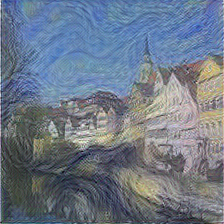

In [164]:
learning_rate = 0.004
epochs = 200

# Define the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)


for epoch in range(epochs):
    with tf.GradientTape() as g:
        generated_vgg = vggoutput(generated)
        content_vgg = vggoutput(content_tensor)
        style_vgg = vggoutput(style_tensor)

        content_loss_value = content_loss(content_vgg[7][0], generated_vgg[7][0])

        style_loss_value = 0
        for i in [1,4, 7, 11, 15]:
            style_loss_value += style_layer_loss(style_vgg[i][0], generated_vgg[i][0])
        style_loss_value /= 5

        total_loss = 1000*style_loss_value + 0.00001*content_loss_value

    grads = g.gradient(total_loss, [generated])
    optimizer.apply_gradients(zip(grads, [generated]))
    if(epoch%10==9):
      print(total_loss)
image = array_to_img(generated[0].numpy())
image


In [166]:
content_loss_value = content_loss(content_vgg[7][0], generated_vgg[7][0])
style_loss_value = 0
for i in [4, 7, 11, 15]:
  style_loss_value += style_layer_loss(style_vgg[i][0], generated_vgg[i][0])
style_loss_value /= 5
0.001*content_loss_value,1000*style_loss_value

(<tf.Tensor: shape=(), dtype=float32, numpy=5171.5557>,
 <tf.Tensor: shape=(), dtype=float32, numpy=60.157635>)

In [165]:
image.save("/content/final_product.jpeg")